In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 61.0 MB/s eta 0:00:00


In [2]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00


In [3]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 75.3 MB/s eta 0:00:00


In [4]:
!pip install gdal
!pip install asf_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7949 sha256=ba83e84516f7abaee64fc0bf8e768f61205d281dc58fe42e22b90a7da8fddd1a
  Stored in directory: /root/.cache/pip/wheels/60/74/6c/b12b4c8fb4b7ab08f495ce17e88f1e98835268af7a8ad5588f
Successfully built remotezip


**Importing Libraries**

In [5]:
import numpy as np
import rasterio as rio
import earthpy.plot as ep
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [6]:
from shapely.geometry import shape
from shapely.geometry import mapping
import rasterio
import geopandas as gpd
import rioxarray as rxr

In [7]:
from sklearn.cluster import KMeans
from osgeo import gdal
import numpy as np
import asf_search as asf

**ASF Search using AOI**

In [ ]:
opts = {
    'platform': asf.PLATFORM.SENTINEL1,
    'start': 'Jan 20, 2020',
    'end' : 'Jan 29,2020',
    'processingLevel': asf.PRODUCT_TYPE.GRD_HD,
    'maxResults': 5
}

In [ ]:
aoi = 'POLYGON((80.0774956675999192 13.0485808965752597,\
               80.3288203326964094 13.0485808965752597,\
               80.3288203326964094 13.2623383471580745,\
               80.0774956675999192 13.2623383471580745,\
               80.0774956675999192 13.0485808965752597))'
results = asf.geo_search(intersectsWith=aoi, **opts)

In [ ]:
results[0].properties

In [ ]:
session = asf.ASFSession()

In [ ]:
import getpass
username = input('Username:')
password = getpass.getpass('Password:')

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

**Data Downloading**

In [ ]:
from os import listdir
with results[0].remotezip(session=user_pass_session) as z:
    file_paths = [file.filename for file in z.filelist if file.filename.endswith('.tiff')]

    print(f'found {len(file_paths)} tiff files in zip')

    for file_path in file_paths:
        z.extract(file_path, path='/content/drive/MyDrive/downloads1')

listdir('/content/drive/MyDrive/downloads1')

**Cropping**

In [ ]:
crop_extent = gpd.read_file('/content/drive/MyDrive/downloads1/extent.shp')
VH = rxr.open_rasterio("/content/drive/MyDrive/downloads1/S1A_IW_GRDH_1SDV_20200126T003149_20200126T003214_030964_038E30_55B7.SAFE/measurement/s1a-iw-grd-vh-20200126t003149-20200126t003214-030964-038e30-002.tiff",
                                 masked=True).squeeze()

In [ ]:
VH_clipped = VH.rio.clip(crop_extent.geometry.apply(mapping))

**Pre-processing**

In [8]:
def normalize(arr):
  min = np.nanmin(arr)
  max = np.nanmax(arr)
  nrm_arr = (arr - min)/(max-min)
  band = np.nan_to_num(nrm_arr)
  return band

In [11]:
sentinel1_VV = rio.open('/content/drive/MyDrive/DP_miniproject/sentinel1_2band.tif').read(1)
sentinel1_VH = rio.open('/content/drive/MyDrive/DP_miniproject/sentinel1_2band.tif').read(2)
band3 = (4*(10**(sentinel1_VH/10)))/((10**(sentinel1_VV/10)) + (10**(sentinel1_VH/10)))
VV = (sentinel1_VV)
VH = (sentinel1_VH)
RVI = (band3)
input = np.stack([VV,VH,RVI])
input.shape

(3, 2372, 2731)

In [ ]:
VV.min()

nan

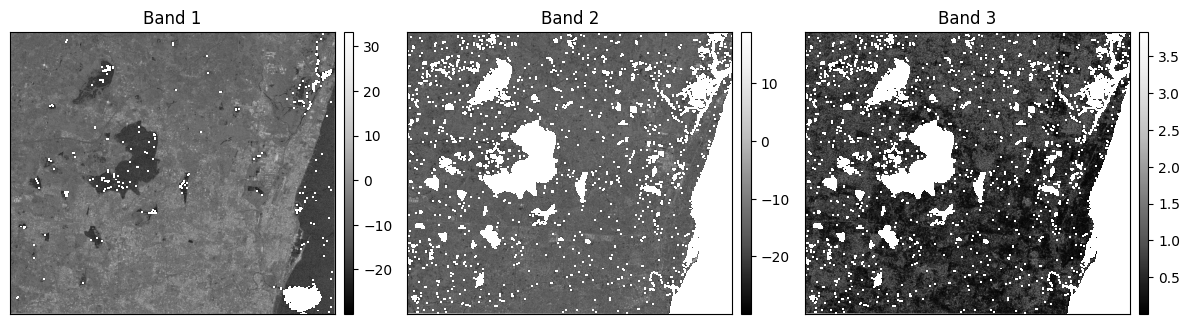

In [ ]:
ep.plot_bands(input)
plt.show()

In [12]:
input_data = np.empty((input.shape[1]*input.shape[2], input.shape[0]))
for i in range(0, 3):
    band = input[i,:,:]
    input_data[:, i] = band.flatten()

In [13]:
input_data_arr = np.nan_to_num(input_data)
input_data_arr.shape

(6477932, 3)

**Unsupervised Classification**

In [14]:
km = KMeans(n_clusters=7)
km.fit(input_data_arr)
km.predict(input_data_arr)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [15]:
out_dat = km.labels_.reshape((input.shape[1], input.shape[2]))

In [16]:
ds = gdal.Open('/content/drive/MyDrive/DP_miniproject/sentinel1_2band.tif')
driverTiff = gdal.GetDriverByName('GTiff')
clfds = driverTiff.Create('/content/drive/MyDrive/DP_miniproject/sentinel1_classified.tif', ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
clfds.SetGeoTransform(ds.GetGeoTransform())
clfds.SetProjection(ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(out_dat)
clfds = None

In [17]:
out_dat = rio.open('/content/drive/MyDrive/DP_miniproject/sentinel1_classified.tif').read(1)

In [20]:
cmap = ListedColormap(['blue','indigo','violet','red','yellow','orange','green'])
# cmap = ListedColormap(['green','blue','red','black','green','orange','green'])

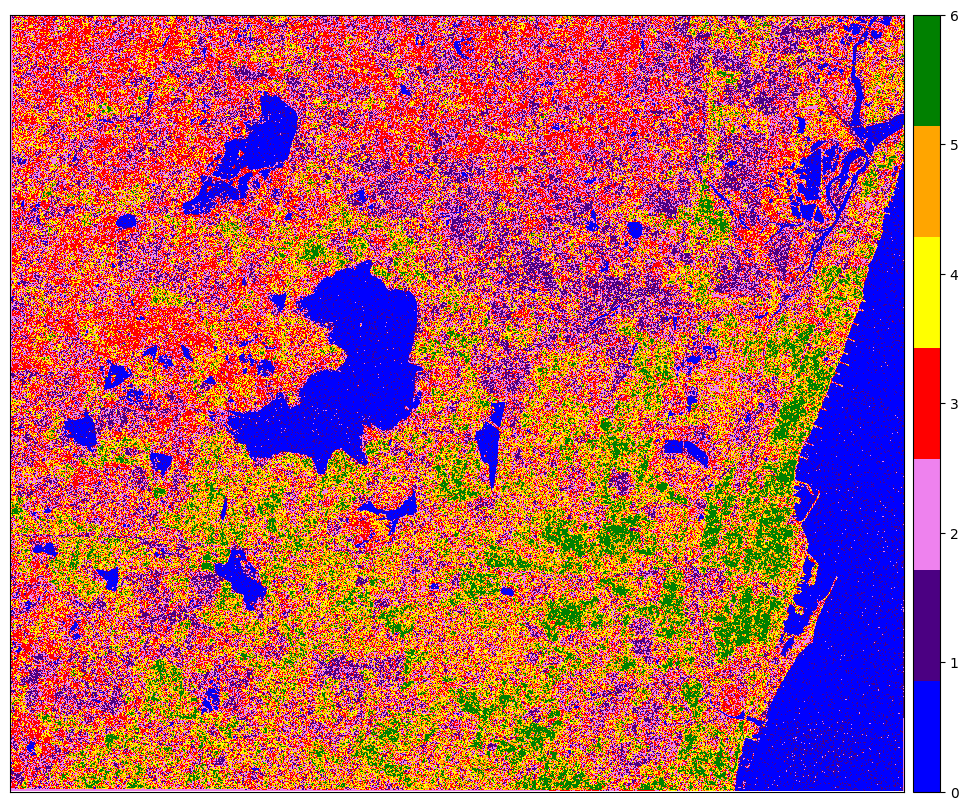

In [21]:
ep.plot_bands(out_dat, 
              cmap=cmap)
plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
sent2 = '/content/drive/MyDrive/DP_miniproject/sentinel2_clipped_10m.tif'
sent2_ds = gdal.Open(sent2)
nsentbands = sent2_ds.RasterCount
sent2_data = []
sent2_12band_data = []
for i in range(1, nsentbands+1):
    bands = sent2_ds.GetRasterBand(i).ReadAsArray()
    bands_nrm = normalize(bands)
    sent2_12band_data.append(bands_nrm)

for i in (3,4,8):
    band = sent2_ds.GetRasterBand(i).ReadAsArray()
    band_nrm = normalize(band)
    sent2_data.append(band_nrm)

In [39]:
sent2 = np.stack(sent2_data)
sent2_12band = np.stack(sent2_12band_data)
sent2.shape

(3, 2372, 2731)

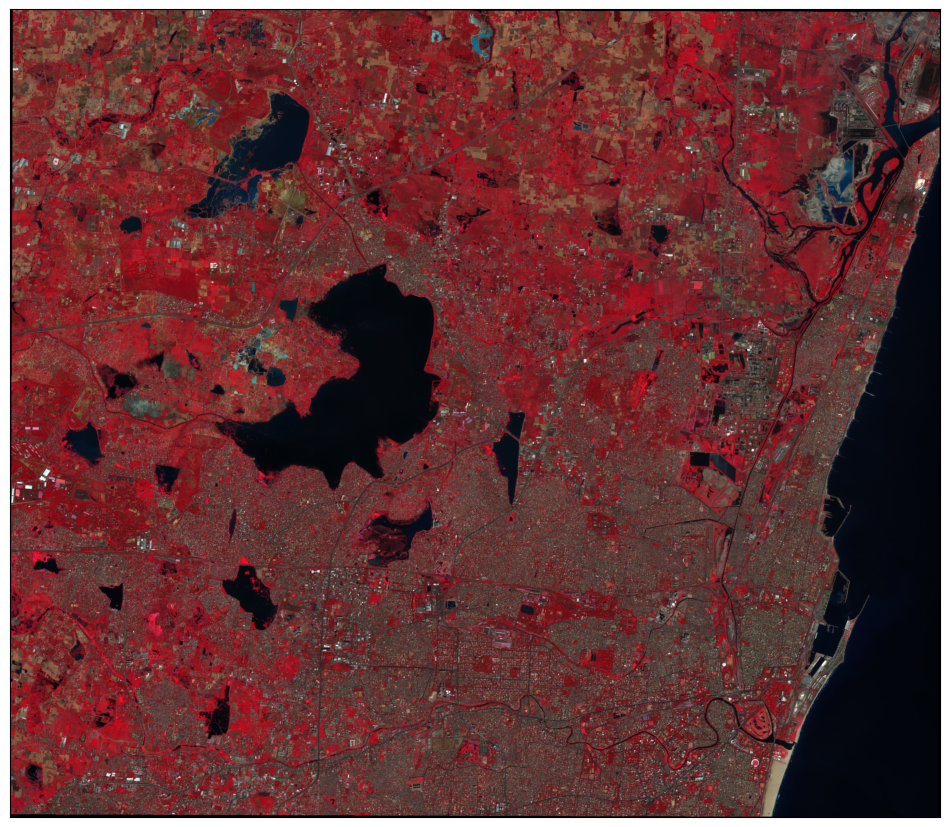

In [ ]:
ep.plot_rgb(
    sent2,
    rgb=(2, 1, 0),
    stretch=True,
    str_clip=0.02,
    figsize=(12, 16),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [40]:
sent2 = np.moveaxis((np.stack(sent2_data)),0,-1)
sent2_12band = np.moveaxis((np.stack(sent2_12band_data)),0,-1)
sent2.shape

(2372, 2731, 3)

In [ ]:
sent_12_data = np.empty((sent2_ds.RasterXSize*sent2_ds.RasterYSize, nsentbands))
for i in range(1, nsentbands+1):
    band = sent2_ds.GetRasterBand(i).ReadAsArray()
    sent_12_data[:, i-1] = band.flatten()

In [ ]:
sent_12_data.shape

(6477932, 12)

In [ ]:
km = KMeans(n_clusters=7)
km.fit(sent_12_data)
km.predict(sent_12_data)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
sent2_class = km.labels_.reshape((sent2_ds.RasterYSize, sent2_ds.RasterXSize))

In [ ]:
driverTiff = gdal.GetDriverByName('GTiff')
clfds = driverTiff.Create('/content/drive/MyDrive/DP_miniproject/sentinel2_classified.tif', sent2_ds.RasterXSize, sent2_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds.SetGeoTransform(sent2_ds.GetGeoTransform())
clfds.SetProjection(sent2_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(sent2_class)
clfds = None

In [22]:
y_data = rio.open('/content/drive/MyDrive/DP_miniproject/sentinel2_classified.tif').read(1)

In [10]:
y_data.shape

(2372, 2731)

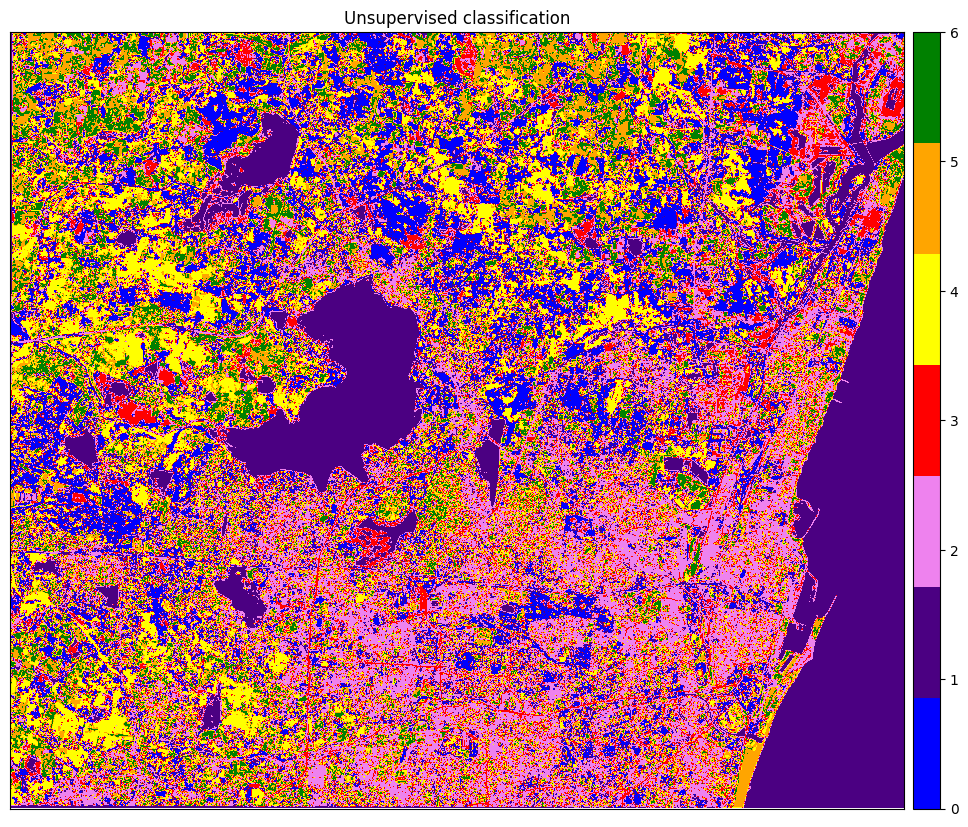

<Axes: title={'center': 'Unsupervised classification'}>

In [27]:
ep.plot_bands(y_data, 
              cmap=cmap, title = 'Unsupervised classification')


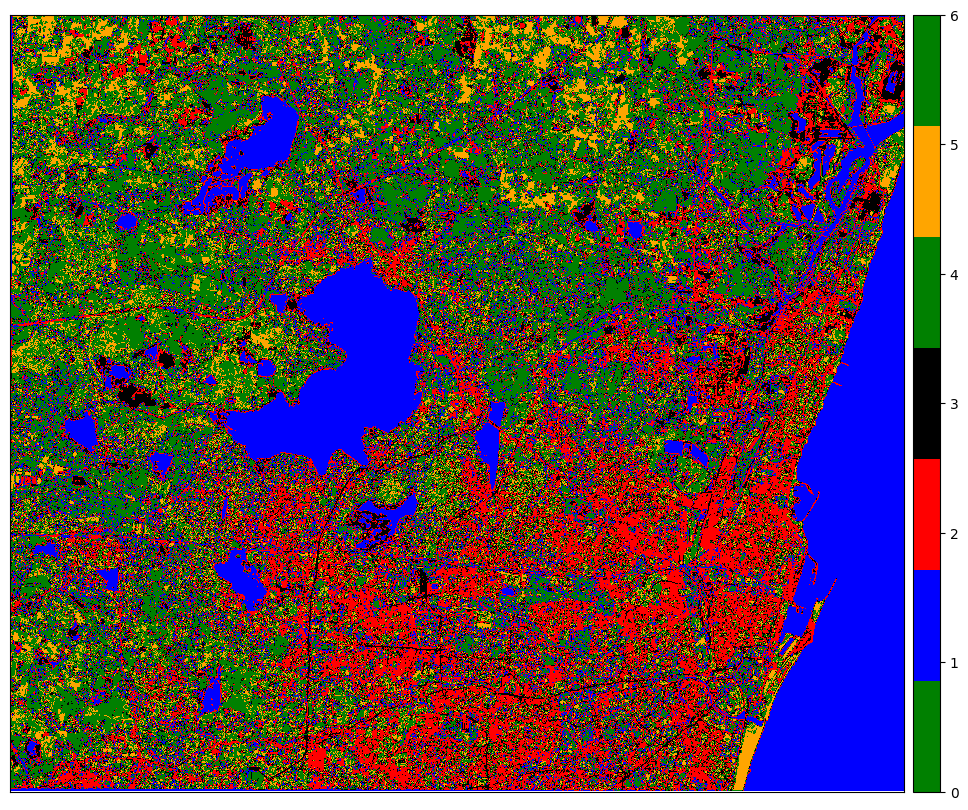

NameError: ignored

In [20]:
#classes = [water,vegetation,built-up,Barren]
cmap1 = ListedColormap(['green','blue','red','black','green','orange','green'])
ep.plot_bands(y_data, 
              cmap=cmap1)

In [28]:
new_data = np.where(y_data == 0,4,y_data)
new_data = np.where(new_data == 6,4,new_data)

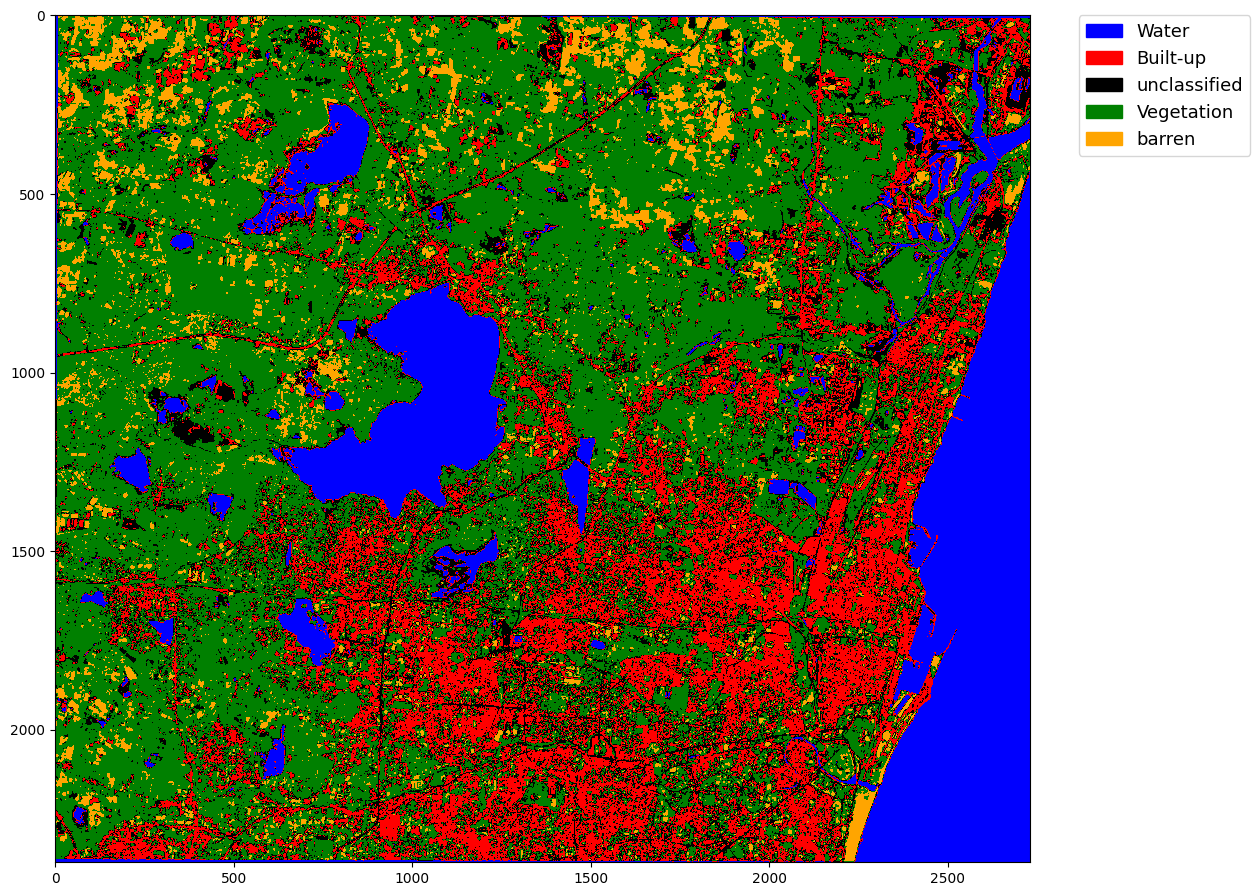

In [31]:
cmap2 = ListedColormap(['blue','red','black','green','orange'])
f, ax = plt.subplots(figsize=(14, 11))
im = ax.imshow(new_data,cmap=cmap2)
ep.draw_legend(
    im,
    titles=["Water", "Built-up","unclassified", "Vegetation", "barren"],
    classes=[1, 2, 3, 4, 5]
)
plt.show()

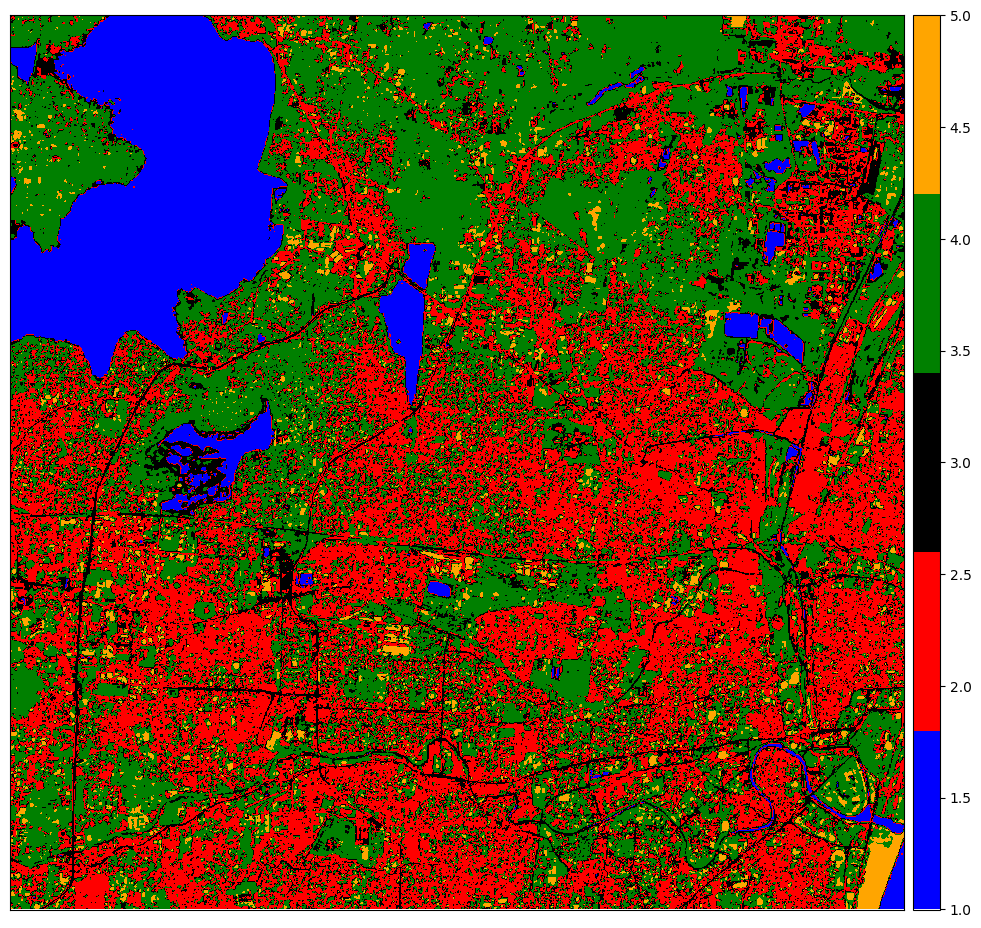

In [32]:
ep.plot_bands(new_data[800:2300,800:2300], 
              cmap=cmap2)
plt.show()

In [33]:
Y_data = new_data[800:2300,800:2300]

In [41]:
sent1_band1 = normalize(VV)
sent1_band2 = normalize(VH)
sent1_band3 = normalize(RVI)
sent1 = np.stack([sent1_band1,sent1_band2,sent1_band3])
sent1 =  np.moveaxis(sent1,0,-1)
print(sent1.shape)
print(sent2.shape)
arr_st = np.dstack((sent1,sent2))
arr_st.shape

(2372, 2731, 3)
(2372, 2731, 3)


(2372, 2731, 6)

In [ ]:
len(Y_data.ravel())

2250000

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# x = np.moveaxis(arr_st, 0, -1)
x = arr_st[800:2300,800:2300]

X_data = x.reshape(-1,6)
X_data.shape
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)



# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_data.ravel(), 
                                                    test_size=0.30, stratify = Y_data.ravel())
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape} \ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (1575000, 6)
X_test Shape: (675000, 6) 
y_train Shape: (1575000,)
y_test Shape:(675000,)


In [ ]:
z = X_train.reshape(-1, 1)

In [ ]:
z.shape

(175000, 1)

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# K-NNC
knn = KNeighborsClassifier(n_neighbors=6)


knn.fit(X_train, y_train)

# Predict the labels of test data

knn_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

print(classification_report(y_test, knn_pred))


Accuracy: 83.51214814814814
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97     63977
         2.0       0.79      0.88      0.83    250568
         3.0       0.73      0.57      0.64     50981
         4.0       0.87      0.83      0.85    290772
         5.0       0.82      0.59      0.69     18702

    accuracy                           0.84    675000
   macro avg       0.84      0.77      0.80    675000
weighted avg       0.84      0.84      0.83    675000



In [ ]:
# from sklearn.svm import SVC

# svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=1024)


# # Fit Data
# svm.fit(X_train, y_train)

# # Predict labels for test data
# svm_pred = svm.predict(X_test)

# # Accuracy and Classification Reeport
# print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
# print(classification_report(y_test, svm_pred))

In [44]:
# sentinel1_3bands = np.moveaxis(arr_st, 0, -1)
band_data = arr_st.reshape(-1,6)
scaler = StandardScaler().fit(band_data)
band_data_scaled = scaler.transform(band_data)
band_data_scaled = np.nan_to_num(band_data_scaled)
band_data_scaled.shape

(6477932, 6)

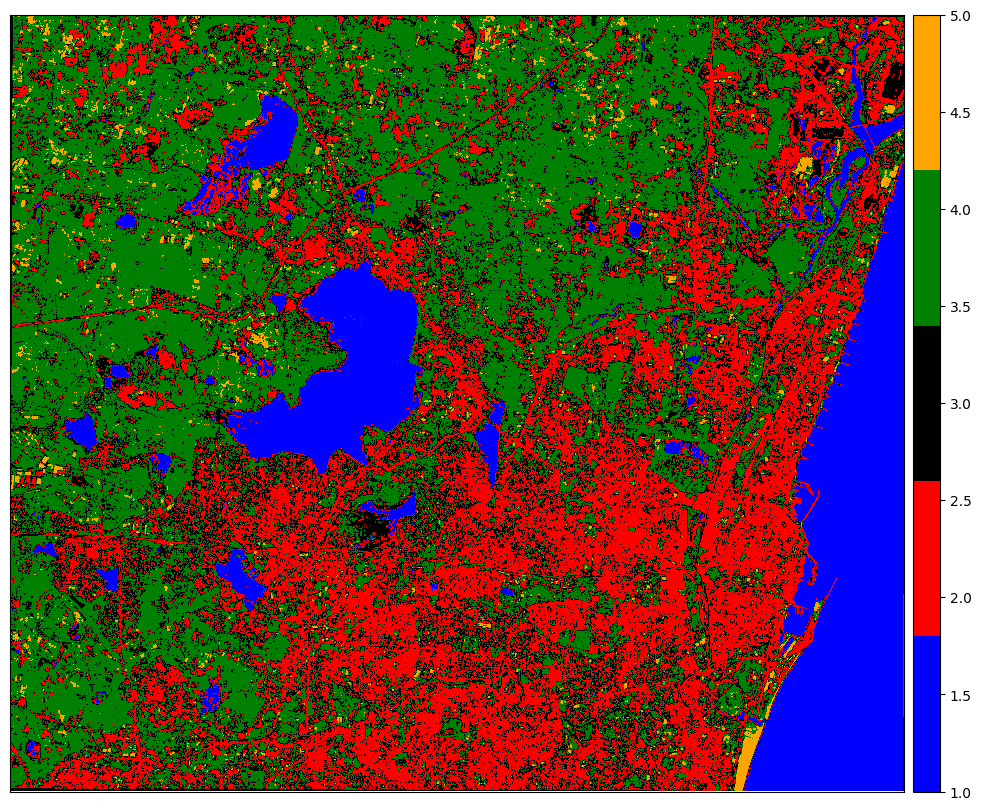

In [45]:
c = knn.predict(band_data_scaled).reshape((2372, 2731))
ep.plot_bands(c, 
              cmap=cmap2)
plt.show()

In [46]:
driverTiff = gdal.GetDriverByName('GTiff')
clfds = driverTiff.Create('/content/drive/MyDrive/DP_miniproject/final_classified.tif', sent2_ds.RasterXSize, sent2_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds.SetGeoTransform(sent2_ds.GetGeoTransform())
clfds.SetProjection(sent2_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(c)
clfds = None

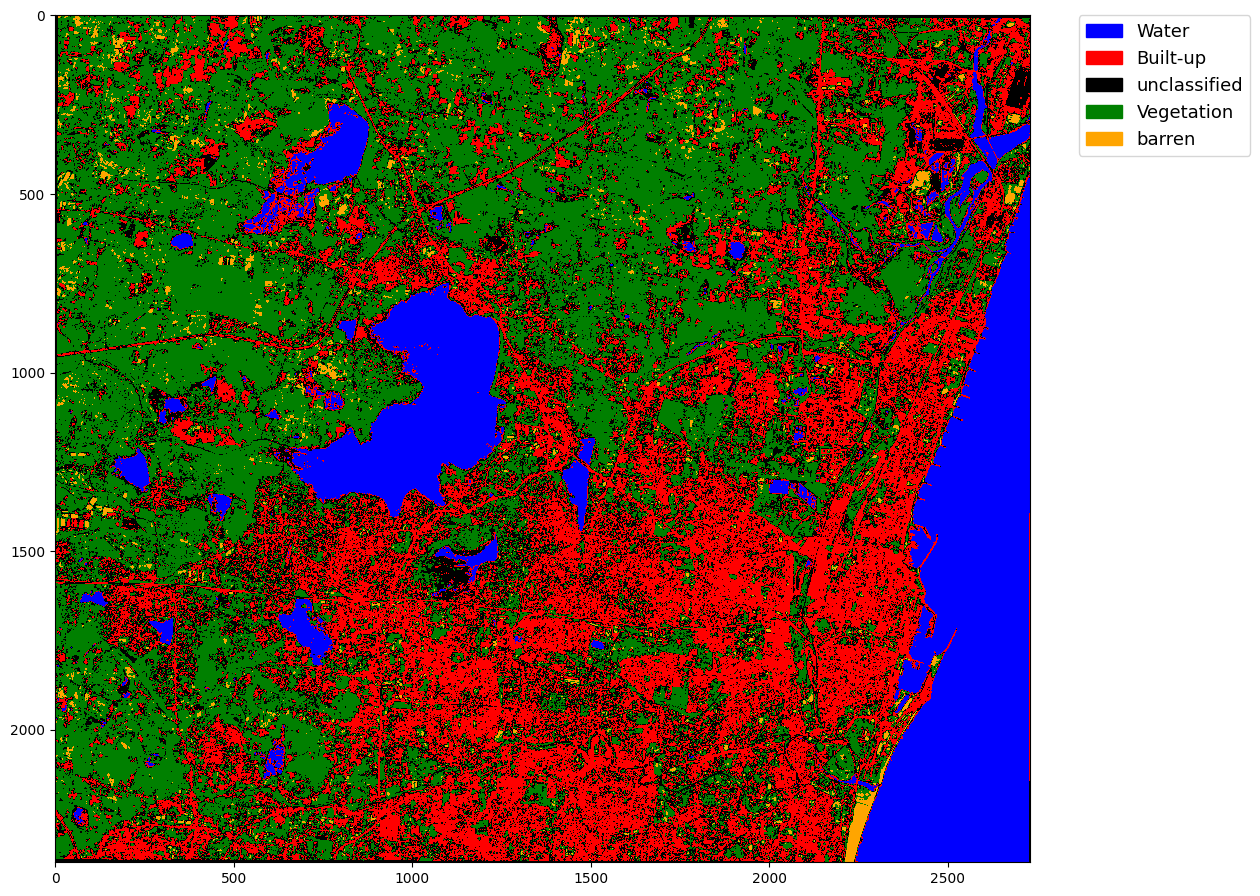

In [47]:
classified = rio.open('/content/drive/MyDrive/DP_miniproject/final_classified.tif').read(1)
f, ax = plt.subplots(figsize=(14, 11))
im = ax.imshow(classified,cmap=cmap2)
ep.draw_legend(
    im,
    titles=["Water", "Built-up","unclassified", "Vegetation", "barren"],
    classes=[1, 2, 3, 4, 5]
)
plt.show()